In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['heart.csv']


In [43]:
# Heart.csv dataset has below columns
#age
#age in years

#sex
#(1 = male; 0 = female)

#cp
#chest pain type

#trestbps
#resting blood pressure (in mm Hg on admission to the hospital)

#chol
#serum cholestoral in mg/dl

#fbs
#(fasting blood sugar &gt; 120 mg/dl) (1 = true; 0 = false)

#restecg
#resting electrocardiographic results

#thalach
#maximum heart rate achieved

#exang
#exercise induced angina (1 = yes; 0 = no)

#oldpeak
#ST depression induced by exercise relative to rest

#slope
#the slope of the peak exercise ST segment

#ca
#number of major vessels (0-3) colored by flourosopy

#thal
#3 = normal; 6 = fixed defect; 7 = reversable defect

#target
#1 or 0

In [44]:
# 1.1 Set maximum columns to 300
pd.options.display.max_columns = 300
# 1.2 Feature creation libraries
from sklearn.random_projection import SparseRandomProjection as sr  # Projection features
from sklearn.cluster import KMeans                    # Cluster features
from sklearn.preprocessing import PolynomialFeatures  # Interaction features

# 1.3 For feature selection
# Ref: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif  # Selection criteria

# 1.4 Data processing
# 1.4.1 Scaling data in various manner
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
# 1.4.2 Transform categorical (integer) to dummy
from sklearn.preprocessing import OneHotEncoder

# 1.5 Splitting data
from sklearn.model_selection import train_test_split

# 1.6 Decision tree modeling
# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree
# http://scikit-learn.org/stable/modules/tree.html#tree
from sklearn.tree import  DecisionTreeClassifier as dt

# 1.7 RandomForest modeling
from sklearn.ensemble import RandomForestClassifier as rf

# 1.8 Plotting libraries to plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

# 1.9 Misc
import os, time, gc

In [45]:
# 2 Read health.csv  into a dataframe df
df = pd.read_csv("../input/heart.csv")
df.shape                            # 303 rows and 14 columns
df.head(10)                         # all rows with target = 1 at the top
df.tail(10)                         # all rows with target = 0 at the bottom
df.columns
df.describe()
df.columns
df.dtypes                           # all columns except for oldpeak is int. oldpeak is float
df.dtypes.value_counts()            #
df.target.value_counts()            # target is binary has 0 or 1 at 54%-45% 
df.fbs.value_counts()
df.restecg.value_counts()
df.ca.value_counts()
# 3 Check for missing values
df.isnull().sum().sum()             # none; sum is zero
df.isna().sum().sum()               # none; sum is zero

# 3.3 Shuffle data as the target is all 0s at the beginning and all 1s at the end  of the input data
df = df.sample(frac = 1)
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
254,59,1,3,160,273,0,0,125,0,0.0,2,0,2,0
273,58,1,0,100,234,0,1,156,0,0.1,2,1,3,0
92,52,1,2,138,223,0,1,169,0,0.0,2,4,2,1
168,63,1,0,130,254,0,0,147,0,1.4,1,1,3,0
75,55,0,1,135,250,0,0,161,0,1.4,1,0,2,1


In [46]:
#Feature Engineering - Using Statistical Numbers
#  4. Feature 1: Row sums of features 1:14. 
df['sum'] = df.sum(numeric_only = True, axis=1)  # numeric_only= None is default
df.head()

# 5. create other statistical features
statfeat = [ "var", "median", "mean", "std", "max", "min"]
for i in statfeat:
    df[i] = df.aggregate(i,  axis =1)
df.head()

# 6. Keep target feature separately
target = df['target']
target.tail(2)

# 7.1 drop 'target' column from df
df.drop(columns = ['target'], inplace = True)
df.shape                # 303 X 20

# 7.2. Store column names of our data in colNames
colNames = df.columns.values
colNames

array(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'sum', 'var',
       'median', 'mean', 'std', 'max', 'min'], dtype=object)

In [47]:
# Feature creation Using Random Projections
# 8. Generate features using random projections
df.shape                          #303 X 20

# 12.2 Transform df to numpy array
# Henceforth we will work with array only
tmp = df.values
tmp.shape                         # (303, 20)

# 13. Let us create 10 random projections/columns
#     This decision, at present, is arbitrary
NUM_OF_COM = 5

# 13.1 Create an instance of class
rp_instance = sr(n_components = NUM_OF_COM)

# 13.2 fit and transform the (original) dataset
#      Random Projections with desired number
#      of components are returned
rp = rp_instance.fit_transform(tmp[:, :13])

# 13.3 Look at some features
rp[: 5, :  3]

# 13.4 Create some column names for these columns
rp_col_names = ["r" + str(i) for i in range(5)]
rp_col_names

['r0', 'r1', 'r2', 'r3', 'r4']

In [48]:
# Feature creation using kmeans

# 14. Before clustering, scale data
# 14.1 Create a StandardScaler instance
se = StandardScaler()
# 14.2 fit() and transform() in one step
tmp = se.fit_transform(tmp)
# 14.3
tmp.shape               # 303 X 20 (an ndarray)

# 16. Perform kmeans using 93 features.
#     No of centroids is no of classes in the 'target'
centers = target.nunique()    # 2 unique classes
centers               # 2

# 17.1 Begin clustering
start = time.time()

# 17.2 First create object to perform clustering
kmeans = KMeans(n_clusters=centers, # How many
                n_jobs = 2)         # Parallel jobs for n_init

# 17.3 Next train the model on the original data only
kmeans.fit(tmp[:, : 13])

end = time.time()
(end-start)/60.0      # 1 minute

# 18 Get clusterlabel for each row (data-point)
kmeans.labels_
kmeans.labels_.size   # 303

303

In [49]:
# 18. Cluster labels are categorical. So convert them to dummy

# 18.1 Create an instance of OneHotEncoder class
ohe = OneHotEncoder(sparse = False)

# 19.2 Use ohe to learn data
#      ohe.fit(kmeans.labels_)
ohe.fit(kmeans.labels_.reshape(-1,1))     # reshape(-1,1) recommended by fit()
                                          # '-1' is a placeholder for actual
# 19.3 Transform data now
dummy_clusterlabels = ohe.transform(kmeans.labels_.reshape(-1,1))
dummy_clusterlabels
dummy_clusterlabels.shape    # 303 X 2 (as many as there are classes)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(303, 2)

In [50]:
# 19.4 We will use the following as names of new nine columns
#      We need them at the end of this code

k_means_names = ["k" + str(i) for i in range(2)]
k_means_names
['k0', 'k1']

['k0', 'k1']

In [51]:
# Interaction features
# 21. Will require lots of memory if we take large number of features
#     Best strategy is to consider only impt features

degree = 2
poly = PolynomialFeatures(degree,                 # Degree 2
                          interaction_only=True,  # Avoid e.g. square(a)
                          include_bias = False    # No constant term
                          )

# 21.1 Consider only first 5 features
#      fit and transform
poly_features =  poly.fit_transform(tmp[:, : 5])

poly_features.shape     # 303 X 15

# 21.2 Generate some names for these 15 columns
poly_names = [ "poly" + str(i)  for i in range(15)]
poly_names

['poly0',
 'poly1',
 'poly2',
 'poly3',
 'poly4',
 'poly5',
 'poly6',
 'poly7',
 'poly8',
 'poly9',
 'poly10',
 'poly11',
 'poly12',
 'poly13',
 'poly14']

In [52]:
# Concatenate all features now

# 22 Append now all generated features together
# 22 Append random projections, kmeans and polynomial features to tmp array

tmp.shape          # 303 X 20

#  22.1 If variable, 'dummy_clusterlabels', exists, stack kmeans generated
#       columns also else not. 'vars()'' is an inbuilt function in python.
#       All python variables are contained in vars().

if ('dummy_clusterlabels' in vars()):               #
    tmp = np.hstack([tmp,rp,dummy_clusterlabels, poly_features])
else:
    tmp = np.hstack([tmp,rp, poly_features])       # No kmeans      <==

tmp.shape         #  (303 X 42)

(303, 42)

In [53]:
# Model building -Decision Tree
# 23. Split train into training and validation dataset
X_train, X_test, y_train, y_test = train_test_split(
                                                    tmp,
                                                    target,
                                                    test_size = 0.3)

# 23.1
X_train.shape    # 212 X 42  
X_test.shape     # 91 X 42; 

# 24 Decision tree classification
# 24.1 Create an instance of class
clf = dt(min_samples_split = 5,
         min_samples_leaf= 5
        )

start = time.time()
# 24.2 Fit/train the object on training data
#      Build model
clf = clf.fit(X_train, y_train)
end = time.time()
(end-start)/60                     # 0.0001824 minute

5.52058219909668e-05

In [54]:
# 24.3 Use model to make predictions
classes = clf.predict(X_test)

# 24.4 Check accuracy
(classes == y_test).sum()/y_test.size      # 74.72%

### Model Building Random Forest

# 25. Instantiate RandomForest classifier
clf = rf(n_estimators=50)

# 25.1 Fit/train the object on training data
#      Build model

start = time.time()
clf = clf.fit(X_train, y_train)
end = time.time()
(end-start)/60

# 25.2 Use model to make predictions
classes = clf.predict(X_test)
# 25.3 Check accuracy
(classes == y_test).sum()/y_test.size      # 81.31%

0.8131868131868132

In [55]:
# Feature selection 
# Using feature importance given by model

list(colNames)
# 26. Get feature importance
clf.feature_importances_        # Column-wise feature importance
clf.feature_importances_.size   # 42

# 26.1 To our list of column names, append all other col names
#      generated by random projection, kmeans (onehotencoding)
#      and polynomial features
#      But first check if kmeans was used to generate features

if ('dummy_clusterlabels' in vars()):       # If dummy_clusterlabels labels are defined
    colNames = list(colNames) + rp_col_names+ k_means_names + poly_names
else:
    colNames = colNames = list(colNames) + rp_col_names +  poly_names      # No kmeans      <==

# 26.1.1 So how many columns?
len(colNames)           # 64
# 26.2 Create a dataframe of feature importance and corresponding
#      column names. Sort dataframe by importance of feature
feat_imp = pd.DataFrame({
                   "importance": clf.feature_importances_ ,
                   "featureNames" : colNames
                  }
                 ).sort_values(by = "importance", ascending=False)

feat_imp.shape                   # 135 X 2 ; without kmeans: (126,2)
feat_imp.head(20)

,importance,featureNames
25,0.119876,k0
26,0.092921,k1
12,0.056385,thal
2,0.050155,cp
29,0.049828,poly2
9,0.043883,oldpeak
33,0.037359,poly6
7,0.033887,thalach
11,0.030147,ca
36,0.028940,poly9


[Text(0, 0, 'k0'),
 Text(0, 0, 'k1'),
 Text(0, 0, 'thal'),
 Text(0, 0, 'cp'),
 Text(0, 0, 'poly2'),
 Text(0, 0, 'oldpeak'),
 Text(0, 0, 'poly6'),
 Text(0, 0, 'thalach'),
 Text(0, 0, 'ca'),
 Text(0, 0, 'poly9'),
 Text(0, 0, 'r0'),
 Text(0, 0, 'poly11'),
 Text(0, 0, 'poly5'),
 Text(0, 0, 'poly0'),
 Text(0, 0, 'var'),
 Text(0, 0, 'age'),
 Text(0, 0, 'r1'),
 Text(0, 0, 'poly13'),
 Text(0, 0, 'poly7'),
 Text(0, 0, 'r2')]

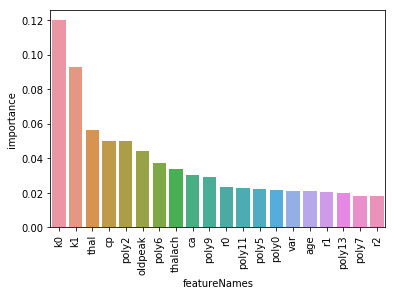

In [56]:
# 26.3 Plot feature importance for first 20 features
g = sns.barplot(x = feat_imp.iloc[  : 20 ,  1] , y = feat_imp.iloc[ : 20, 0])
g.set_xticklabels(g.get_xticklabels(),rotation=90)